**导入数据库**

In [2]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
#超参数设置
batch_size = 100   #训练集块大小

learning_rate = 0.001   #学习率
numepochs = 20     #迭代次数


transformation_train = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 
# Compose的意思是将多个transform组合在一起用，
#ToTensor 将像素转化为[0,1]的数字，Normalize则正则化变为 [-1,1]
transformation_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 导入数据集
train_dataset = datasets.CIFAR10(root='./root', train=True,  download=True, transform=transformation_train)
test_dataset  = datasets.CIFAR10(root='./root', train=False, download=True, transform=transformation_test)


# 创建数据加载器
# 开启shuffle就等于全集使用SubsetRandomSampler，都是随机采样,
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=True,num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

Extracting ./root/cifar-10-python.tar.gz to ./root
Files already downloaded and verified


In [4]:
#查看数据集规格
train_iterator = iter(train_loader)
train_images, train_labels = train_iterator.next()
print( train_images.shape )
print( train_labels.shape )

torch.Size([100, 3, 32, 32])
torch.Size([100])


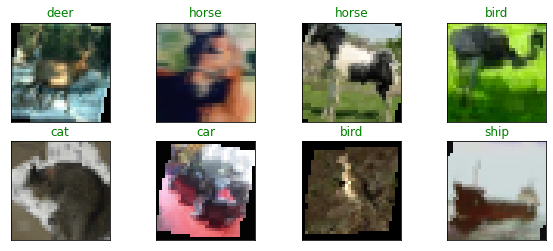

In [6]:
# 主要目的验证数据是否正确
def imshow(img):
    img = img / 2 + 0.5  # 非规范化
    plt.imshow(np.transpose(img, (1, 2, 0)))  # 转换张量图像
   
# 随机获取一批样本
train_iterator = iter(train_loader)
train_images, train_labels = train_iterator.next()
train_images = train_images.numpy() #将图像转换为numpy显示

# 显示图像，标题为类名
fig = plt.figure(figsize=(10, 4))
# 显示8张图片
for id in np.arange(8):
    ax = fig.add_subplot(2, 4, id+1, xticks=[], yticks=[])
    imshow(train_images[id])
    ax.set_title(classes[train_labels[id]],color="green")

In [7]:
#采用全卷积层的结构：

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding = 1)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2, 2)
        self.globalavgpool = nn.AvgPool2d(8, 8)
        self.bn1 = nn.BatchNorm2d(64) #归一化
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout50 = nn.Dropout(0.5)
        self.dropout10 = nn.Dropout(0.1)
        self.fc = nn.Linear(256, 10)
 
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn1(F.relu(self.conv2(x)))
        x = self.maxpool(x)
        x = self.dropout10(x)
        x = self.bn2(F.relu(self.conv3(x)))
        x = self.bn2(F.relu(self.conv4(x)))
        x = self.avgpool(x)
        x = self.dropout10(x)
        x = self.bn3(F.relu(self.conv5(x)))
        x = self.bn3(F.relu(self.conv6(x)))
        x = self.globalavgpool(x)
        x = self.dropout50(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
cnn = CNN()
# 如有GPU则自动使用GPU计算
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
cnn.to(device)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (globalavgpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout50): Dropout(p=0.5, inplace=False)
 

In [8]:
# 损失函数
loss_func = nn.CrossEntropyLoss()  # 交叉熵损失函数
# 优化器
# Adam 优化算法是随机梯度下降算法的扩展式
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)    

In [10]:
#定义整个训练过程
train_count = len(train_loader) * batch_size
test_count  = len(test_loader)  * batch_size
train_losses = []
test_losses  = []
train_acurracies = []
test_acurracies  = []

# 开始迭代
for epoch in range(numepochs):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
  
    # 使用训练集进行训练
    for train_images, train_labels in train_loader:
    
        # 将图像和标签部署到GPU上，更快一些
        train_images = train_images.to( device )
        train_labels = train_labels.to( device )
    
        # 计算当前批次训练集上的损失度

        output = cnn(train_images) 
        loss = loss_func(output, train_labels)
    
        # 更新权重
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    
        # 计算当前批次训练集上的准确度
        predictions = torch.max( output , 1)[1] 
        acurracy = torch.sum( predictions == train_labels )
    
        # 将准确度、损失度分别相加
        train_acc += acurracy 
        train_loss += loss.item()
    
    print("EPOCH --> " + str(epoch + 1))
    print("----------------------------------------------")
  
    # 在同一批次内测试当前模型
    for test_images, test_labels in test_loader:
    
        
        test_images = test_images.to( device )
        test_labels = test_labels.to( device )
    
       
        output = cnn(test_images)
        loss = loss_func(output, test_labels)
    
        # 当前批次的准确度
        predictions = torch.max( output , 1)[1] 
        acurracy = torch.sum( predictions == test_labels )
    
        
        test_acc += acurracy 
        test_loss += loss.item()
 
    # 打印当前批次训练集的准确度、损失度 
    train_acc = float(train_acc.float()) / train_count
    train_acurracies.append( train_acc )
    print("Train Acurracy: " + str( float(train_acc) ))
    
    train_loss = train_loss / train_count
    train_losses.append( train_loss )
    print("Train Loss: " + str(train_loss) + "\n")
  
    # 打印当前批次测试集的准确度、损失度
    test_acc = float(test_acc.float()) / test_count
    test_acurracies.append( test_acc )
    print("Test Acurracy: " + str( float(test_acc) ))    
    
    test_loss = test_loss / test_count
    test_losses.append( test_loss )
    print("Test Loss: " + str(test_loss))
    print("----------------------------------------------\n")

EPOCH --> 1
----------------------------------------------
Train Acurracy: 0.46124
Train Loss: 0.014743786492347716

Test Acurracy: 0.5882
Test Loss: 0.011494061440229415
----------------------------------------------

EPOCH --> 2
----------------------------------------------
Train Acurracy: 0.61776
Train Loss: 0.010695842671394349

Test Acurracy: 0.683
Test Loss: 0.009053345501422881
----------------------------------------------

EPOCH --> 3
----------------------------------------------
Train Acurracy: 0.69018
Train Loss: 0.008777299312353134

Test Acurracy: 0.7422
Test Loss: 0.007398552453517913
----------------------------------------------

EPOCH --> 4
----------------------------------------------
Train Acurracy: 0.74132
Train Loss: 0.007494103597998619

Test Acurracy: 0.7786
Test Loss: 0.006420264250040054
----------------------------------------------

EPOCH --> 5
----------------------------------------------
Train Acurracy: 0.7704
Train Loss: 0.006674761282205581

Test Acur

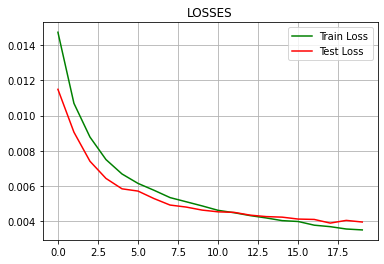

In [11]:
# 绘制损失图
plt.title("LOSSES")
plt.plot(train_losses, label = "Train Loss", color= "green")
plt.plot(test_losses,  label = "Test Loss", color= "red")
plt.legend()
plt.grid()

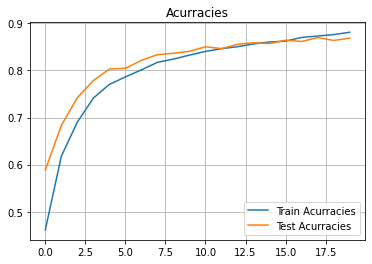

In [12]:
#绘制准确度图像
plt.title("Acurracies")
plt.plot(train_acurracies, label = "Train Acurracies")
plt.plot(test_acurracies,  label = "Test Acurracies")
plt.legend()
plt.grid()

In [13]:
#测试集每个分类的准确度
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 89 %
Accuracy of  bird : 85 %
Accuracy of   cat : 67 %
Accuracy of  deer : 92 %
Accuracy of   dog : 83 %
Accuracy of  frog : 97 %
Accuracy of horse : 87 %
Accuracy of  ship : 88 %
Accuracy of truck : 93 %


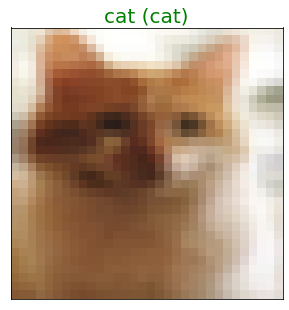

In [48]:
# 随机选取照片显示
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

#预测结果 
output = cnn(images.to(device))
_, preds_tensor = torch.max(output.cpu(), 1)
preds = np.squeeze(preds_tensor.numpy())

# 显示一张图片的预测结果，括号里为标签值
fig = plt.figure(figsize=(30, 5))
for idx in np.arange(1):
    ax = fig.add_subplot(1, 1, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"),size='20')
    